In [2]:
import random
N = 10
G = 5
gateways = [{'P': random.randint(1, 10), 'S': random.randint(50, 100), 'Y': random.choice([0, 1])} for _ in range(G)]
nodes = [{'d': random.randint(1, 50), 'B': random.randint(10, 100)} for _ in range(N)]

connections = {}

for i in range(N):
    for g in range(G):
        if (g, i) not in connections:
            connections[(i, g)] = {'P': random.randint(1, 5), 'X': random.choice([0, 1])}

print("Gateways:")
for i, gateway in enumerate(gateways):
    print(f"Gateway {i}: Power to setup (P)={gateway['P']}, Storage (S)={gateway['S']}, On/Off (Y)={gateway['Y']}")

print("\nNodes:")
for i, node in enumerate(nodes):
    print(f"Node {i}: Data to transfer (d)={node['d']}, Battery (B)={node['B']}")

print("\nConnections:")
for (i, g), connection in connections.items():
    print(f"Node {i} to Gateway {g}: Power (P)={connection['P']}, Link (X)={connection['X']}")



Gateways:
Gateway 0: Power to setup (P)=6, Storage (S)=78, On/Off (Y)=1
Gateway 1: Power to setup (P)=6, Storage (S)=67, On/Off (Y)=0
Gateway 2: Power to setup (P)=2, Storage (S)=90, On/Off (Y)=1
Gateway 3: Power to setup (P)=10, Storage (S)=72, On/Off (Y)=0
Gateway 4: Power to setup (P)=8, Storage (S)=69, On/Off (Y)=0

Nodes:
Node 0: Data to transfer (d)=9, Battery (B)=34
Node 1: Data to transfer (d)=32, Battery (B)=56
Node 2: Data to transfer (d)=37, Battery (B)=32
Node 3: Data to transfer (d)=40, Battery (B)=40
Node 4: Data to transfer (d)=2, Battery (B)=25
Node 5: Data to transfer (d)=42, Battery (B)=98
Node 6: Data to transfer (d)=46, Battery (B)=76
Node 7: Data to transfer (d)=39, Battery (B)=62
Node 8: Data to transfer (d)=4, Battery (B)=10
Node 9: Data to transfer (d)=7, Battery (B)=33

Connections:
Node 0 to Gateway 0: Power (P)=2, Link (X)=0
Node 0 to Gateway 1: Power (P)=3, Link (X)=0
Node 0 to Gateway 2: Power (P)=3, Link (X)=1
Node 0 to Gateway 3: Power (P)=5, Link (X)=1
N

In [3]:
!pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 40.1 MB/s eta 0:00:00


# Facility Location Problem using Linear Programming

In [4]:
import random
from pulp import *
import matplotlib.pyplot as plt


results_flp = {
    'total_data_transferred': [],
    'node_count': [],
    'gateway_count': [],
    'total_setup_power': [],
    'total_storage': [],
    'total_data': []
}


N = 10
G = 5

for iteration in range(50):
    gateways = [{'P': random.randint(1, 10), 'S': random.randint(50, 100), 'Y': random.choice([0, 1])} for _ in range(G)]
    nodes = [{'d': random.randint(1, 50), 'B': random.randint(10, 100)} for _ in range(N)]

    connections = {(i, g): {'P': random.randint(1, 5), 'X': random.choice([0, 1])} for i in range(N) for g in range(G)}

    problem = LpProblem("FacilityLocationProblem", LpMaximize)

    Yg_vars = LpVariable.dicts("Yg", range(G), cat='Binary')
    dig_vars = LpVariable.dicts("dig", [(i, g) for i in range(N) for g in range(G)], lowBound=0)

    problem += lpSum([dig_vars[(i, g)] for i in range(N) for g in range(G)])

    for i in range(N):
        problem += lpSum([dig_vars[(i, g)] for g in range(G)]) <= nodes[i]['d']
        problem += lpSum([connections[(i, g)]['P'] * dig_vars[(i, g)] for g in range(G)]) <= nodes[i]['B']

    for g in range(G):
        problem += lpSum([dig_vars[(i, g)] for i in range(N)]) <= gateways[g]['S'] * Yg_vars[g]

    problem.solve()

    total_data_transferred = sum([dig_vars[(i, g)].varValue for i in range(N) for g in range(G) if dig_vars[(i, g)].varValue is not None])
    total_setup_power = sum([gateways[g]['P'] * Yg_vars[g].varValue for g in range(G) if sum([dig_vars[(i, g)].varValue for i in range(N) if dig_vars[(i, g)].varValue is not None]) > 0])
    total_storage = sum([gateways[g]['S'] for g in range(G)])
    total_data = sum([nodes[i]['d'] for i in range(N)])

    results_flp['total_data_transferred'].append(total_data_transferred)
    results_flp['node_count'].append(N)
    results_flp['gateway_count'].append(G)
    results_flp['total_setup_power'].append(total_setup_power)
    results_flp['total_storage'].append(total_storage)
    results_flp['total_data'].append(total_data)

    N += 4
    G += 2


# Maximizing Flow Theorem using Ford-Fulkerson algorithm

In [5]:
import random
import networkx as nx
import matplotlib.pyplot as plt

total_data_transferred_list_mft = []
total_setup_power_list_mft = []
node_count_list_mft = []
gateway_count_list_mft = []
total_storage_list_mft = []
total_data_list_mft = []

N = 10
G = 5

common_multiplier = 2

for _ in range(50):
    G_flow = nx.DiGraph()

    nodes_data = {f'node_{i}': {'d': random.randint(10, 100), 'B': random.randint(10, 100)} for i in range(N)}
    gateways_storage = {f'gateway_{i}': random.randint(50, 150) for i in range(G)}
    gateways_power = {f'gateway_{i}': random.randint(1, 10) for i in range(G)}

    total_data = sum(data['d'] for data in nodes_data.values())
    total_storage = sum(storage for storage in gateways_storage.values())

    for node, data in nodes_data.items():
        for gateway, power in gateways_power.items():
            if random.choice([True, False]):
                capacity = min(data['B'], power) * common_multiplier
                G_flow.add_edge(node, gateway, capacity=capacity)

    G_flow.add_node('super_source')
    G_flow.add_node('super_sink')

    for node, data in nodes_data.items():
        G_flow.add_edge('super_source', node, capacity=data['d'])
    for gateway, storage in gateways_storage.items():
        G_flow.add_edge(gateway, 'super_sink', capacity=storage)

    flow_value, flow_dict = nx.maximum_flow(G_flow, 'super_source', 'super_sink')

    for gateway in gateways_storage:
        total_data_transferred_to_gateway = sum(flow_dict.get(node, {}).get(gateway, 0) for node in nodes_data)
        if total_data_transferred_to_gateway > gateways_storage[gateway]:
            excess_data = total_data_transferred_to_gateway - gateways_storage[gateway]
            for node in nodes_data:
                excess_flow = min(flow_dict[node].get(gateway, 0), excess_data)
                flow_dict[node][gateway] -= excess_flow
                excess_data -= excess_flow
                if excess_data == 0:
                    break

    total_setup_power = sum(gateways_power[gateway] for gateway in gateways_power if any(flow_dict.get(gateway, {}).values()))

    total_data_transferred_list_mft.append(flow_value)
    total_setup_power_list_mft.append(total_setup_power)
    node_count_list_mft.append(N)
    gateway_count_list_mft.append(G)
    total_storage_list_mft.append(total_storage)
    total_data_list_mft.append(total_data)

    N += 4
    G += 2


# Greedy Set Cover

In [6]:
def greedy_set_cover(S, w):
    C = set()
    f_C = lambda C: set.union(*map(set, C)) if C else set()
    while f_C(C) != f_C(S):
        s = min(S - C, key=lambda s: w[s] / (len(f_C(C | {s})) - len(f_C(C))))
        C |= {s}
    return C

total_data_transferred_list_scp = []
total_setup_power_list_scp = []
node_count_list_scp = []
gateway_count_list_scp = []
total_storage_list_scp = []
total_data_list_scp = []

N = 10
G = 5

for iteration in range(50):
    nodes = [{'d': random.randint(1, 50), 'B': random.randint(10, 100)} for _ in range(N)]
    gateways = [{'S': random.randint(50, 100), 'P': random.randint(1, 10)} for _ in range(G)]

    connections = {(i, g): random.choice([0, 1]) for i in range(N) for g in range(G)}

    S = {frozenset({(i, g) for i in range(N) for g in range(G) if connections[(i, g)] == 1})}
    w = {s: sum(gateways[g]['P'] for i, g in s) for s in S}

    C = greedy_set_cover(S, w)

    total_data_transferred = sum(nodes[i]['d'] for i in range(N) if any((i, g) in c for c in C for g in range(G)))
    total_setup_power = sum(gateways[g]['P'] for g in range(G) if any((i, g) in c for c in C for i in range(N)))
    total_storage = sum(gateways[g]['S'] for g in range(G))
    total_data = sum(nodes[i]['d'] for i in range(N))

    total_data_transferred_list_scp.append(total_data_transferred)
    total_setup_power_list_scp.append(total_setup_power)
    node_count_list_scp.append(N)
    gateway_count_list_scp.append(G)
    total_storage_list_scp.append(total_storage)
    total_data_list_scp.append(total_data)

    N += 4
    G += 2


# Plots

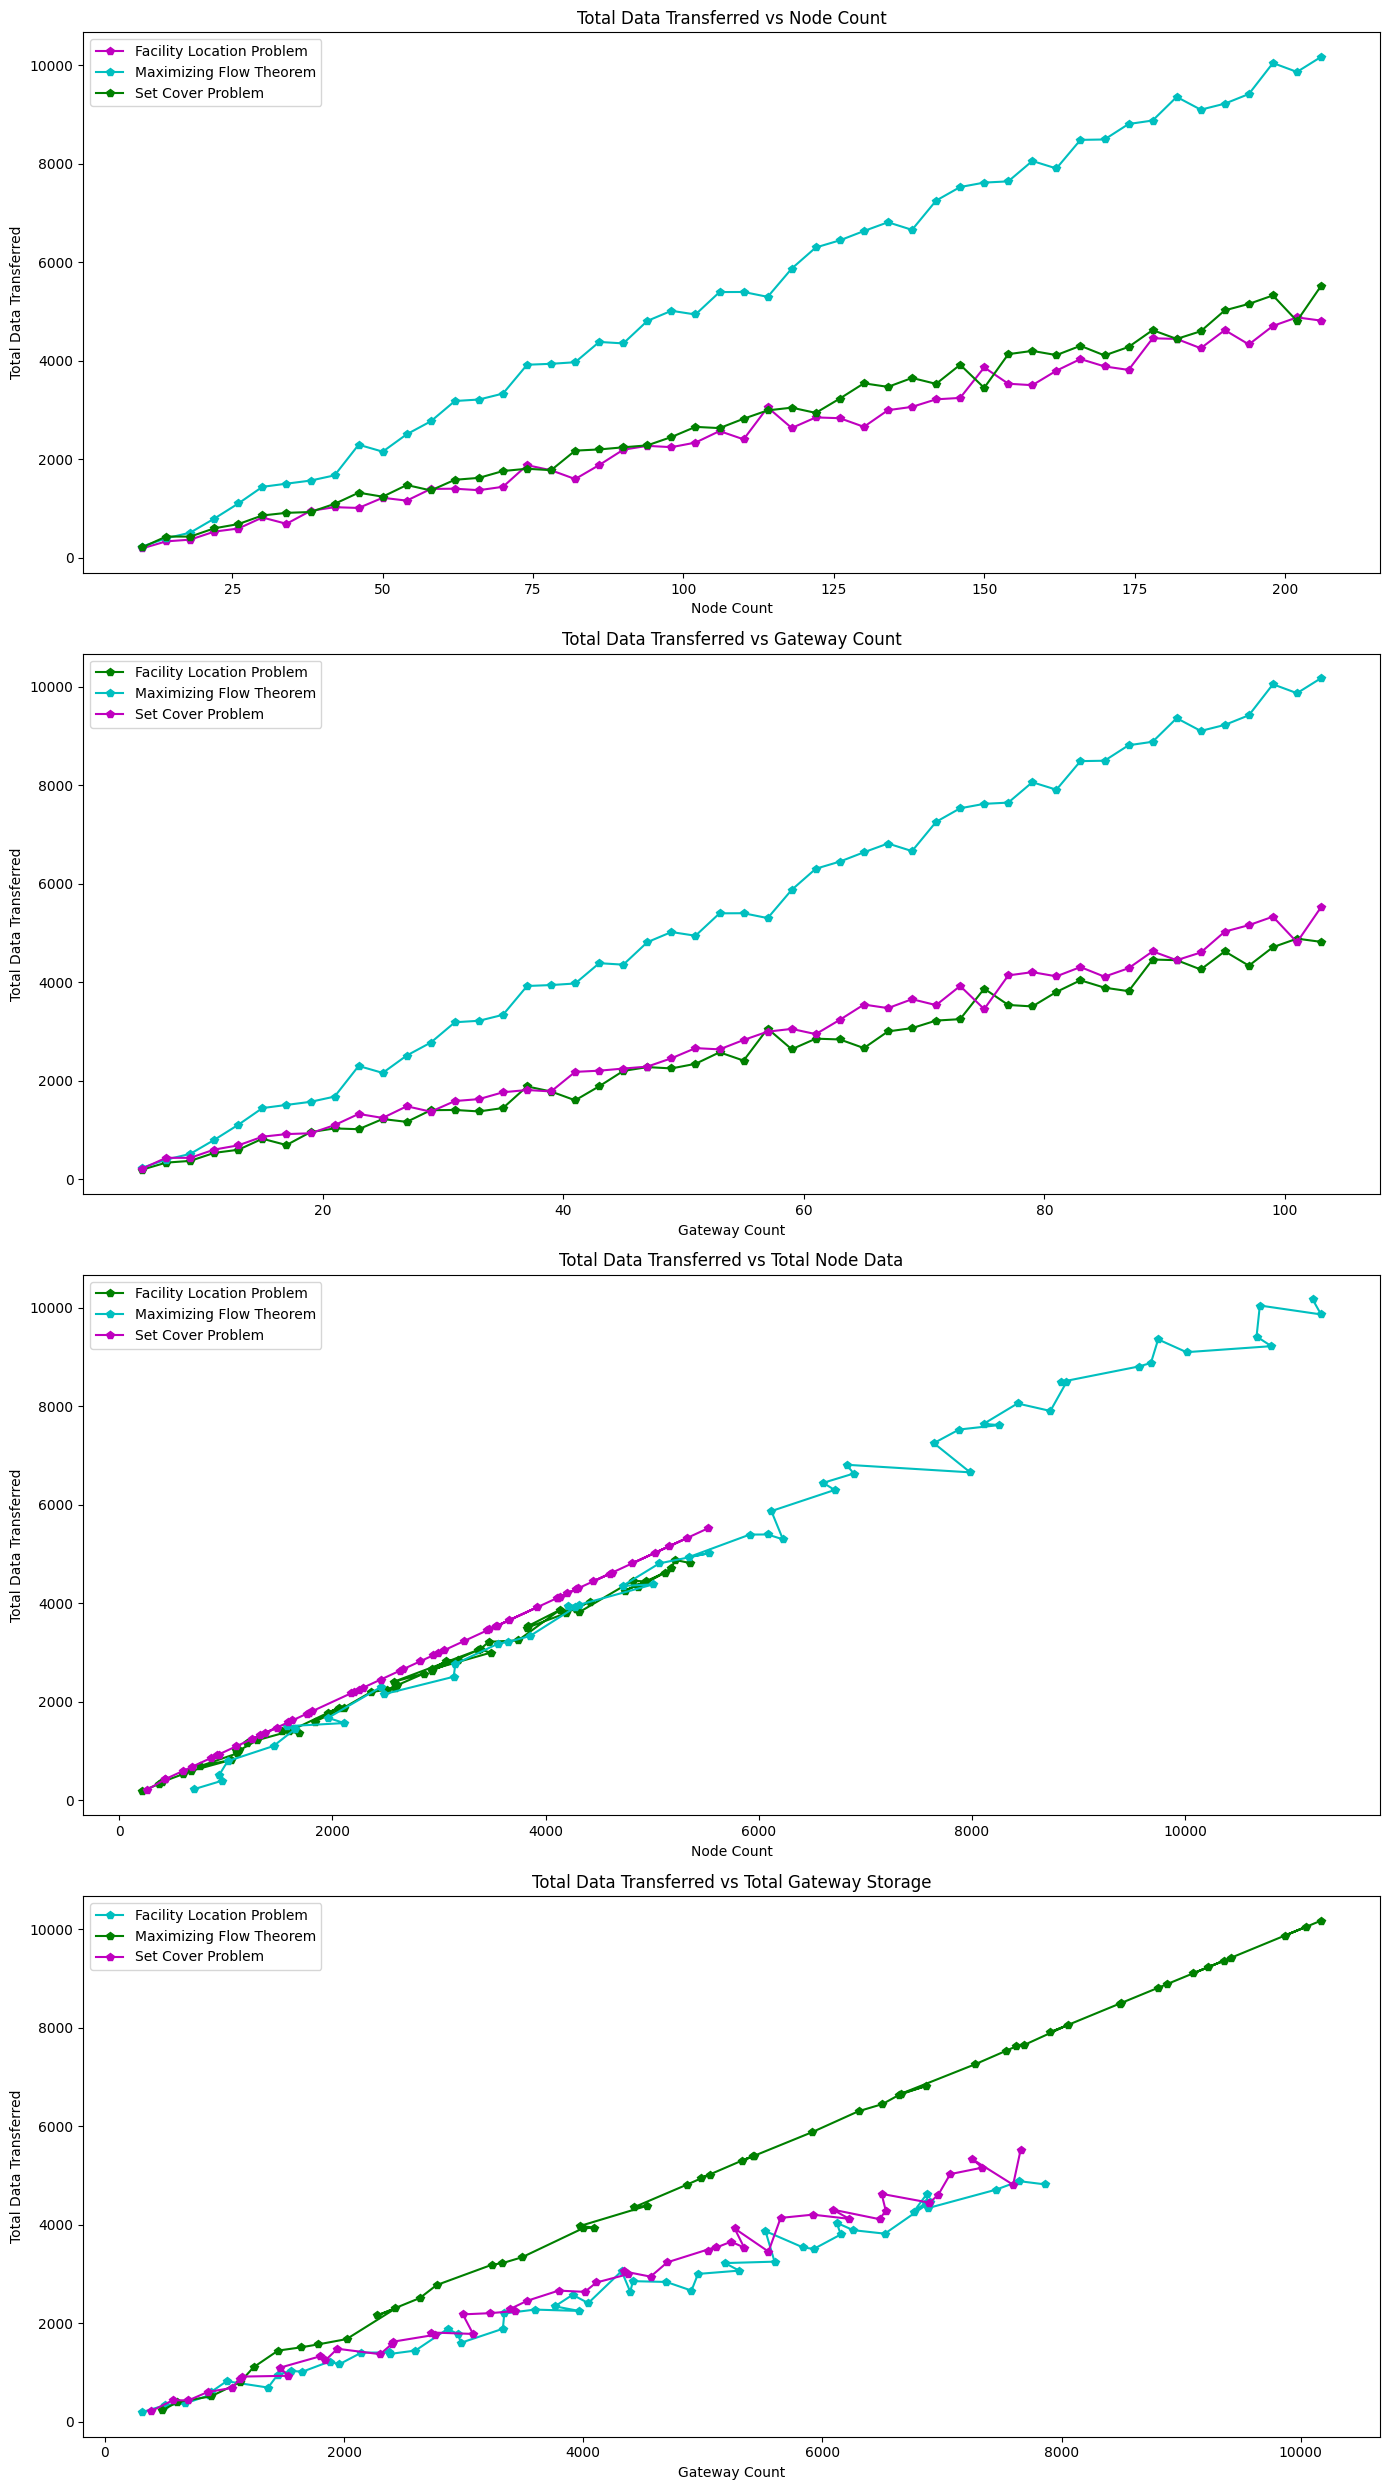

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 25))  # Adjusted figsize for vertical arrangement

# Total Data Transferred vs Node Count
plt.subplot(4, 1, 1)  # Changed subplot to arrange vertically
plt.plot(results_flp['node_count'], results_flp['total_data_transferred'], 'mp-', label='Facility Location Problem')  # Changed marker style and color
plt.plot(node_count_list_mft, total_data_transferred_list_mft, 'cp-', label='Maximizing Flow Theorem')  # Changed marker style and color
plt.plot(node_count_list_scp, total_data_transferred_list_scp, 'gp-', label='Set Cover Problem')  # Changed marker style and color
plt.title('Total Data Transferred vs Node Count')
plt.xlabel('Node Count')
plt.ylabel('Total Data Transferred')
plt.legend()

# Total Data Transferred vs Gateway Count
plt.subplot(4, 1, 2)  # Changed subplot to arrange vertically
plt.plot(results_flp['gateway_count'], results_flp['total_data_transferred'], 'gp-', label='Facility Location Problem')  # Changed marker style and color
plt.plot(gateway_count_list_mft, total_data_transferred_list_mft, 'cp-', label='Maximizing Flow Theorem')  # Changed marker style and color
plt.plot(gateway_count_list_scp, total_data_transferred_list_scp, 'mp-', label='Set Cover Problem')  # Changed marker style and color
plt.title('Total Data Transferred vs Gateway Count')
plt.xlabel('Gateway Count')
plt.ylabel('Total Data Transferred')
plt.legend()

# Total Setup Power vs Node Count
plt.subplot(4, 1, 3)  # Changed subplot to arrange vertically
plt.plot(results_flp['total_data'], results_flp['total_data_transferred'], 'gp-', label='Facility Location Problem')  # Changed marker style and color
plt.plot(total_data_list_mft, total_data_transferred_list_mft, 'cp-', label='Maximizing Flow Theorem')  # Changed marker style and color
plt.plot(total_data_list_scp, total_data_transferred_list_scp, 'mp-', label='Set Cover Problem')  # Changed marker style and color
plt.title('Total Data Transferred vs Total Node Data')
plt.xlabel('Node Count')
plt.ylabel('Total Data Transferred')
plt.legend()

# Total Data Transferred vs Gateway Count
plt.subplot(4, 1, 4)  # Changed subplot to arrange vertically
plt.plot(results_flp['total_storage'], results_flp['total_data_transferred'], 'cp-', label='Facility Location Problem')  # Changed marker style and color
plt.plot(total_storage_list_mft, total_data_transferred_list_mft, 'gp-', label='Maximizing Flow Theorem')  # Changed marker style and color
plt.plot(total_storage_list_scp, total_data_transferred_list_scp, 'mp-', label='Set Cover Problem')  # Changed marker style and color
plt.title('Total Data Transferred vs Total Gateway Storage')
plt.xlabel('Gateway Count')
plt.ylabel('Total Data Transferred')
plt.legend()

plt.tight_layout()
plt.show()



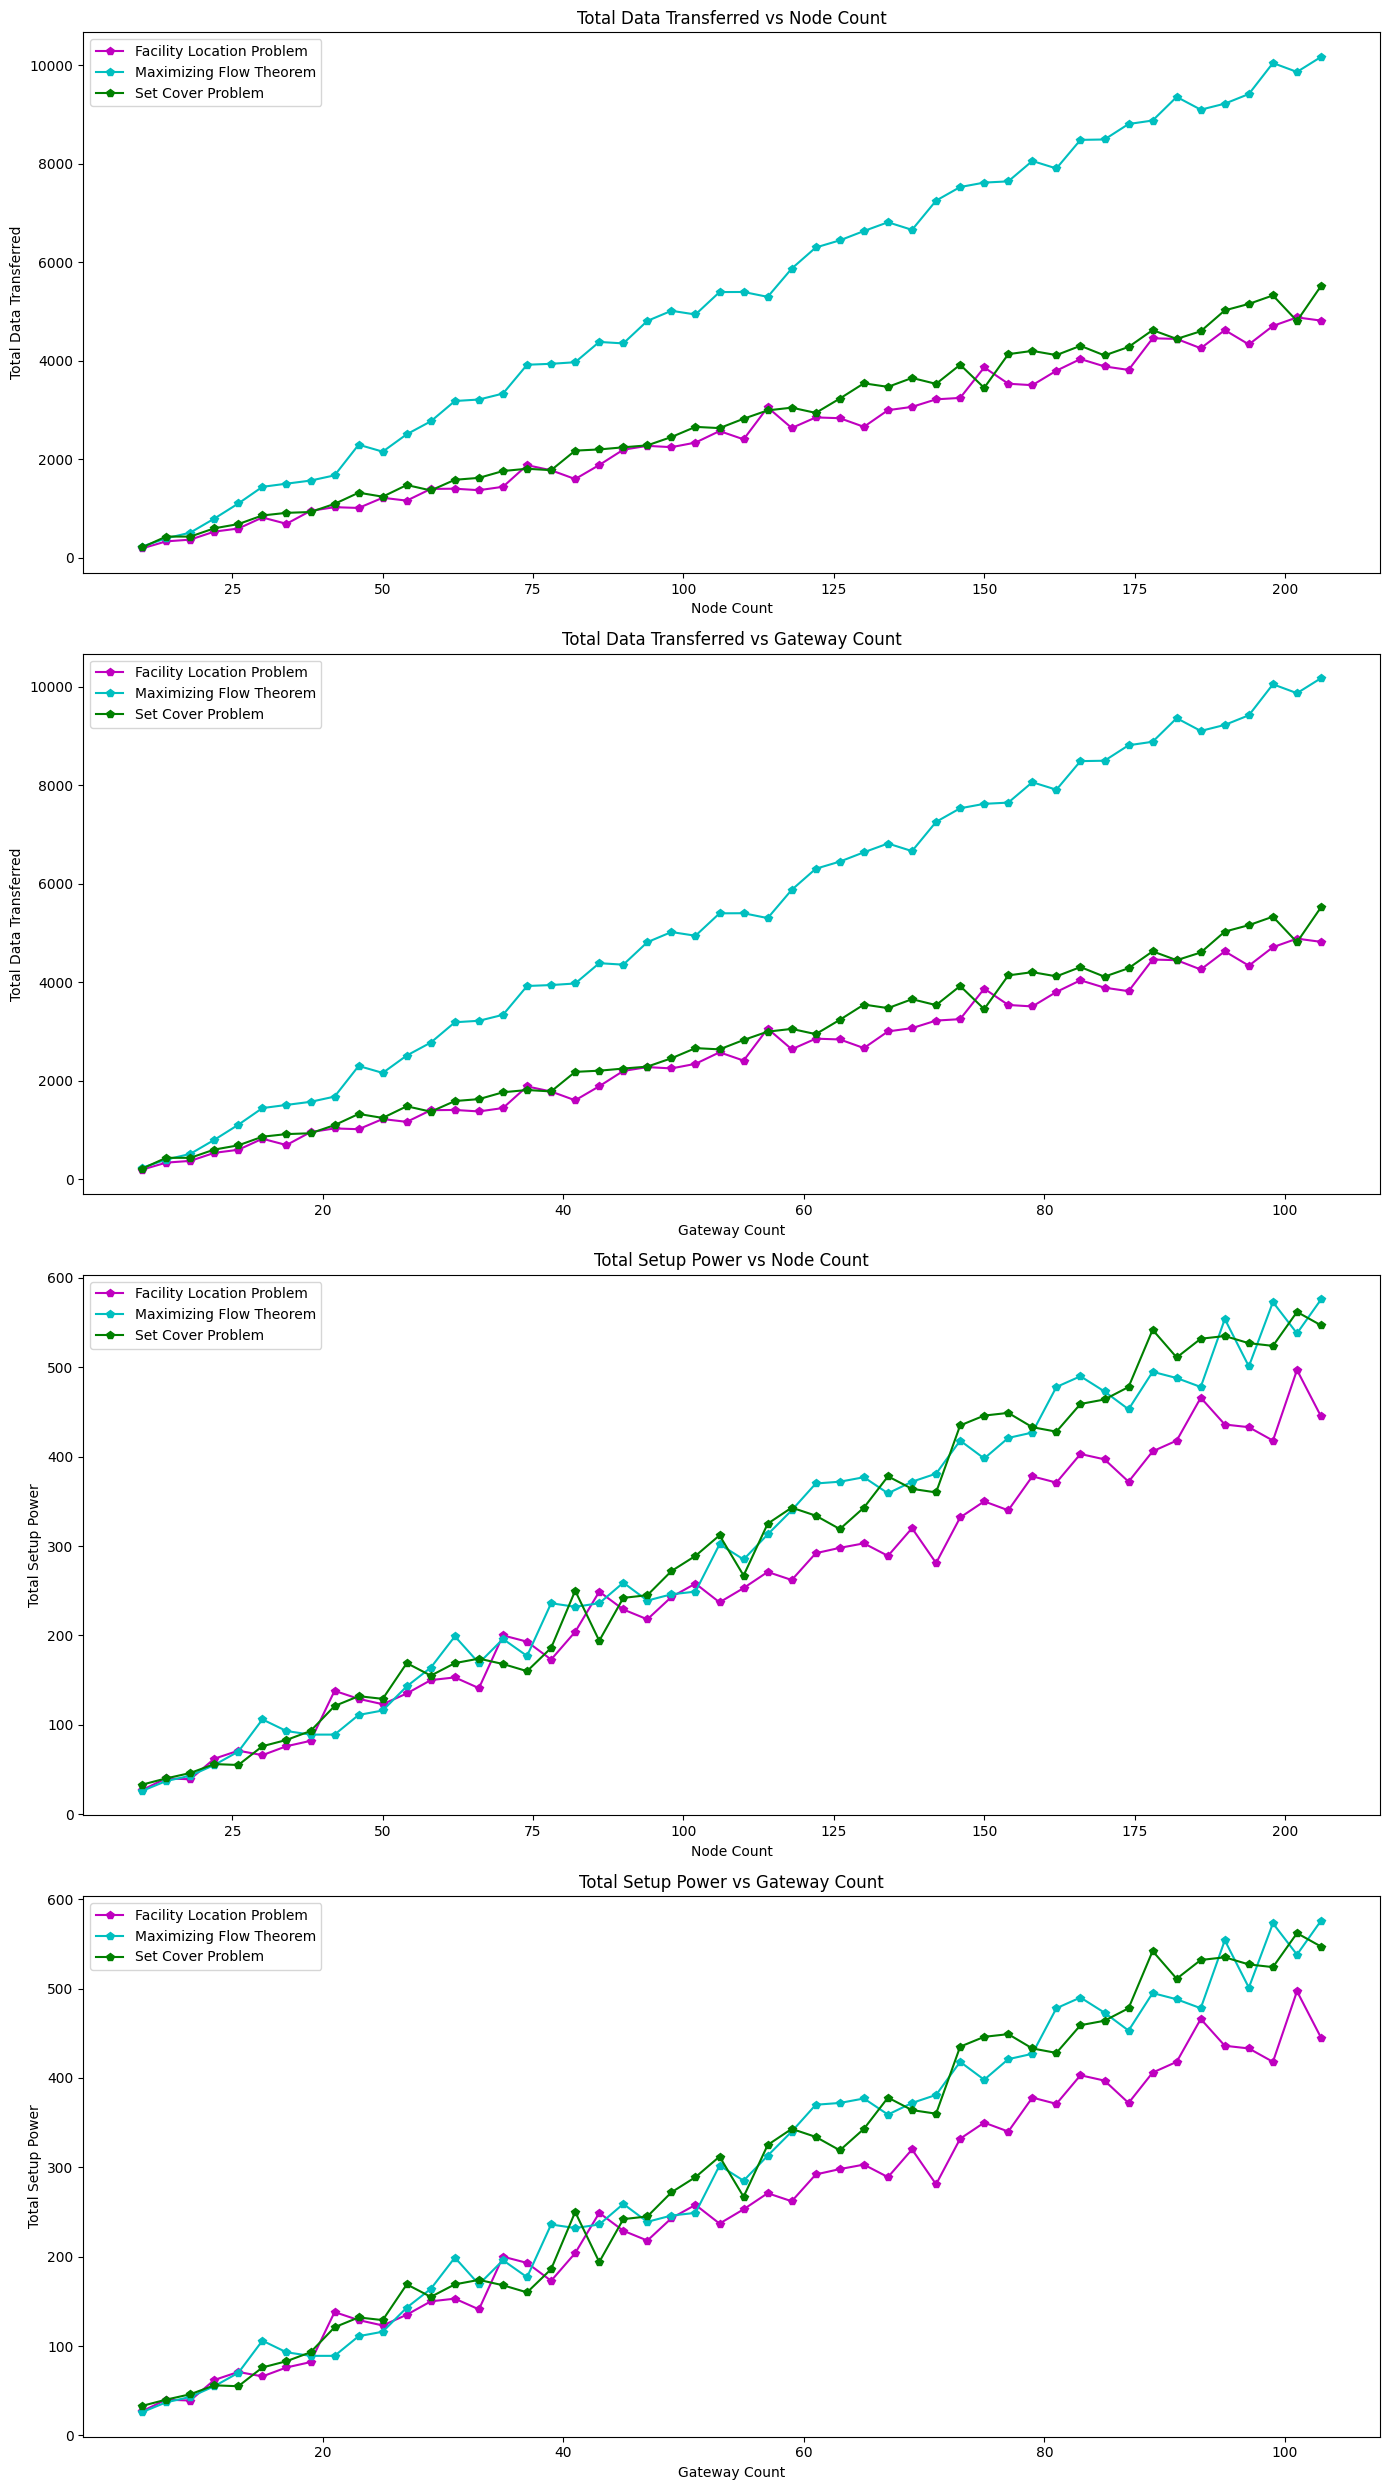

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 25))  # Adjusted figsize for vertical arrangement

# Total Data Transferred vs Node Count
plt.subplot(4, 1, 1)
plt.plot(results_flp['node_count'], results_flp['total_data_transferred'], 'mp-', label='Facility Location Problem')
plt.plot(node_count_list_mft, total_data_transferred_list_mft, 'cp-', label='Maximizing Flow Theorem')
plt.plot(node_count_list_scp, total_data_transferred_list_scp, 'gp-', label='Set Cover Problem')
plt.title('Total Data Transferred vs Node Count')
plt.xlabel('Node Count')
plt.ylabel('Total Data Transferred')
plt.legend()

# Total Data Transferred vs Gateway Count
plt.subplot(4, 1, 2)
plt.plot(results_flp['gateway_count'], results_flp['total_data_transferred'], 'mp-', label='Facility Location Problem')
plt.plot(gateway_count_list_mft, total_data_transferred_list_mft, 'cp-', label='Maximizing Flow Theorem')
plt.plot(gateway_count_list_scp, total_data_transferred_list_scp, 'gp-', label='Set Cover Problem')
plt.title('Total Data Transferred vs Gateway Count')
plt.xlabel('Gateway Count')
plt.ylabel('Total Data Transferred')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(results_flp['node_count'], results_flp['total_setup_power'], 'mp-', label='Facility Location Problem')
plt.plot(node_count_list_mft, total_setup_power_list_mft, 'cp-', label='Maximizing Flow Theorem')
plt.plot(node_count_list_scp, total_setup_power_list_scp, 'gp-', label='Set Cover Problem')
plt.title('Total Setup Power vs Node Count')
plt.xlabel('Node Count')
plt.ylabel('Total Setup Power')
plt.legend()

# Total Setup Power vs Gateway Count
plt.subplot(4, 1, 4)
plt.plot(results_flp['gateway_count'], results_flp['total_setup_power'], 'mp-', label='Facility Location Problem')
plt.plot(gateway_count_list_mft, total_setup_power_list_mft, 'cp-', label='Maximizing Flow Theorem')
plt.plot(gateway_count_list_scp, total_setup_power_list_scp, 'gp-', label='Set Cover Problem')
plt.title('Total Setup Power vs Gateway Count')
plt.xlabel('Gateway Count')
plt.ylabel('Total Setup Power')
plt.legend()

plt.tight_layout()
plt.show()


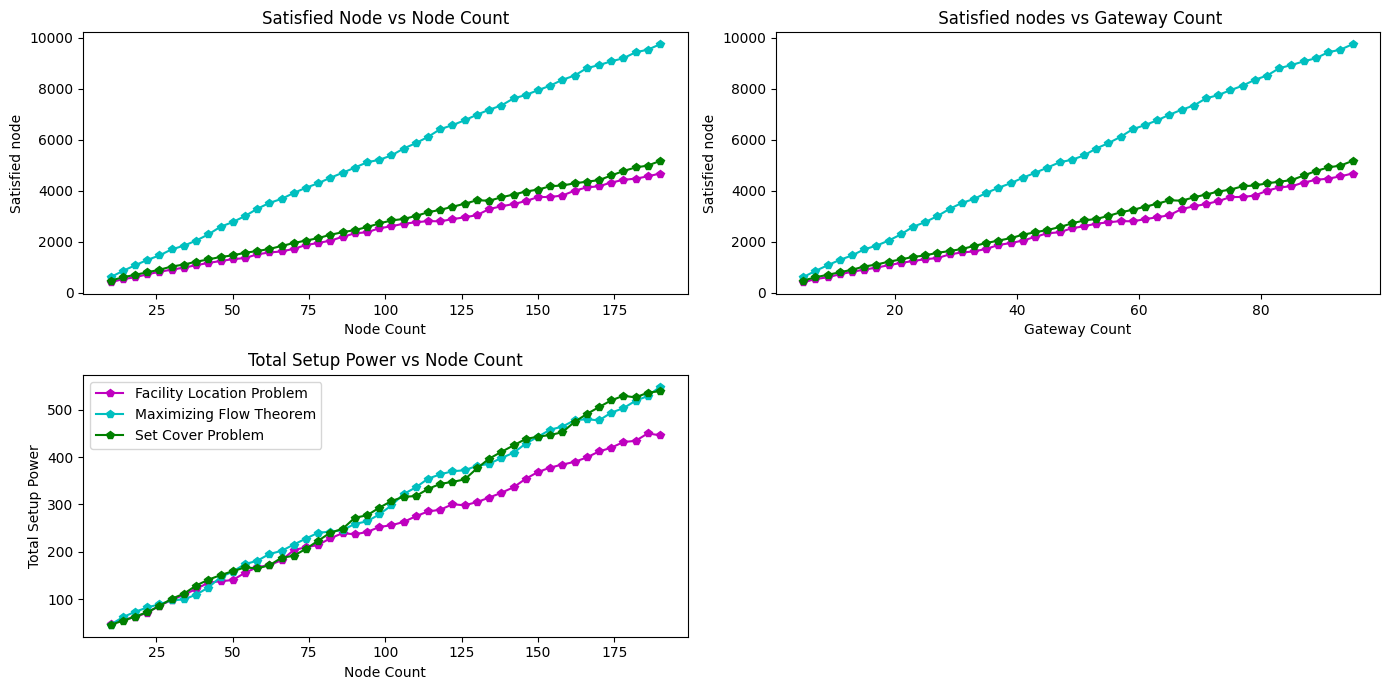

In [23]:
import numpy as np
import matplotlib.pyplot as plt


def moving_average(data, window_size):
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size


window_size = 5
smoothed_total_data_transferred_flp = moving_average(results_flp['total_data_transferred'], window_size)
smoothed_total_data_transferred_mft = moving_average(total_data_transferred_list_mft, window_size)
smoothed_total_data_transferred_scp = moving_average(total_data_transferred_list_scp, window_size)

# Plotting the smoothed results
plt.figure(figsize=(14, 7))
plt.subplot(2, 2, 1)
plt.plot(results_flp['node_count'][:-window_size+1], smoothed_total_data_transferred_flp, 'mp-', label='Facility Location Problem')
plt.plot(node_count_list_mft[:-window_size+1], smoothed_total_data_transferred_mft, 'cp-', label='Maximizing Flow Theorem')
plt.plot(node_count_list_scp[:-window_size+1], smoothed_total_data_transferred_scp, 'gp-', label='Set Cover Problem')

plt.title('Satisfied Node vs Node Count')
plt.xlabel('Node Count')
plt.ylabel('Satisfied node')

# Total Data Transferred vs Gateway Count
window_size = 5  # Adjust the window size as needed
smoothed_total_data_transferred_flp = moving_average(results_flp['total_data_transferred'], window_size)
smoothed_total_data_transferred_mft = moving_average(total_data_transferred_list_mft, window_size)
smoothed_total_data_transferred_scp = moving_average(total_data_transferred_list_scp, window_size)

# Plotting the smoothed results
plt.subplot(2, 2, 2)
plt.plot(results_flp['gateway_count'][:-window_size+1], smoothed_total_data_transferred_flp, 'mp-', label='Facility Location Problem')
plt.plot(gateway_count_list_mft[:-window_size+1], smoothed_total_data_transferred_mft, 'cp-', label='Maximizing Flow Theorem')
plt.plot(gateway_count_list_scp[:-window_size+1], smoothed_total_data_transferred_scp, 'gp-', label='Set Cover Problem')
plt.title(' Satisfied nodes vs Gateway Count')
plt.xlabel('Gateway Count')
plt.ylabel('Satisfied node')

# Total Setup Power vs Node Count
window_size = 5  # Adjust the window size as needed
smoothed_total_setup_power_flp = moving_average(results_flp['total_setup_power'], window_size)
smoothed_total_setup_power_mft = moving_average(total_setup_power_list_mft, window_size)
smoothed_total_setup_power_scp = moving_average(total_setup_power_list_scp, window_size)

# Plotting the smoothed results
plt.subplot(2, 2, 3)
plt.plot(results_flp['node_count'][:-window_size+1], smoothed_total_setup_power_flp, 'mp-', label='Facility Location Problem')
plt.plot(node_count_list_mft[:-window_size+1], smoothed_total_setup_power_mft, 'cp-', label='Maximizing Flow Theorem')
plt.plot(node_count_list_scp[:-window_size+1], smoothed_total_setup_power_scp, 'gp-', label='Set Cover Problem')
plt.title('Total Setup Power vs Node Count')
plt.xlabel('Node Count')
plt.ylabel('Total Setup Power')
plt.legend()

# Total Setup Power vs Total Data Transferred


plt.tight_layout()
plt.show()
